# Demo of SVI using simulated data for 50000 individuals

We begin by performing the necessary imports:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import logging
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Fix random seed for reproducibility
np.random.seed(42)

# Generate simulated data

We predefine the fixed effects parameters (true_alpha) and random effects parameters (true_beta), as well as the covariance matrix (true_Omega), and sample simulated choice data for 50000 respondents (num_resp), each with 10 choice situations (num_menus). The number of choice alternatives is set to 5. 

In [2]:
from core.dcm_fakedata import generate_fake_data_wide

num_resp = 50000
num_menus = 10
num_alternatives = 5

true_alpha = np.array([-0.8, 0.8, 1.2])
true_beta = np.array([-0.8, 0.8, 1.0, -0.8, 1.5])
# dynamic version of generating Omega
corr = 0.8
scale_factor = 1.0
true_Omega = corr*np.ones((len(true_beta),len(true_beta))) # off-diagonal values of cov matrix
true_Omega[np.arange(len(true_beta)), np.arange(len(true_beta))] = 1.0 # diagonal values of cov matrix
true_Omega *= scale_factor

df = generate_fake_data_wide(num_resp, num_menus, num_alternatives, true_alpha, true_beta, true_Omega)
df.head()

Generating fake data...
Error: 46.0406


,ALT1_XF1,ALT1_XF2,ALT1_XF3,ALT1_XR1,ALT1_XR2,ALT1_XR3,ALT1_XR4,ALT1_XR5,ALT2_XF1,ALT2_XF2,...,ALT5_XR1,ALT5_XR2,ALT5_XR3,ALT5_XR4,ALT5_XR5,choice,indID,menuID,obsID,ones
0,0.374540,0.950714,0.731994,0.340311,0.768842,0.936032,0.481857,0.802253,0.598658,0.156019,...,0.809189,0.914568,0.789045,0.110962,0.312995,1,0,0,0,1
1,0.183405,0.304242,0.524756,0.194837,0.796218,0.651730,0.237908,0.199814,0.431945,0.291229,...,0.536775,0.940645,0.826931,0.510653,0.914976,4,0,1,1,1
2,0.607545,0.170524,0.065052,0.485441,0.186343,0.322737,0.514758,0.090070,0.948886,0.965632,...,0.595050,0.947324,0.927226,0.962351,0.211986,3,0,2,2,1
3,0.662522,0.311711,0.520068,0.442947,0.350437,0.031725,0.790190,0.481335,0.546710,0.184854,...,0.846481,0.875187,0.624215,0.993924,0.414757,4,0,3,3,1
4,0.388677,0.271349,0.828738,0.011319,0.689977,0.119363,0.251674,0.674041,0.356753,0.280935,...,0.890742,0.984823,0.531394,0.295977,0.364010,2,0,4,4,1


# Mixed Logit specification

We now make use of the developed formula interface to specify the utilities of the mixed logit model. 

We begin by defining the fixed effects parameters, the random effects parameters, and the observed variables. This creates instances of Python objects that can be put together to define the utility functions for the different alternatives.

Once the utilities are defined, we collect them in a Python dictionary mapping alternative names to their corresponding expressions.

In [3]:
from core.dcm_interface import FixedEffect, RandomEffect, ObservedVariable

# define fixed effects parameters
B_XF1 = FixedEffect('BETA_XF1')
B_XF2 = FixedEffect('BETA_XF2')
B_XF3 = FixedEffect('BETA_XF3')

# define random effects parameters
B_XR1 = RandomEffect('BETA_XR1')
B_XR2 = RandomEffect('BETA_XR2')
B_XR3 = RandomEffect('BETA_XR3')
B_XR4 = RandomEffect('BETA_XR4')
B_XR5 = RandomEffect('BETA_XR5')

# define observed variables
for attr in df.columns:
    exec("%s = ObservedVariable('%s')" % (attr,attr))

# define utility functions
V1 = B_XF1*ALT1_XF1 + B_XF2*ALT1_XF2 + B_XF3*ALT1_XF3 + B_XR1*ALT1_XR1 + B_XR2*ALT1_XR2 + B_XR3*ALT1_XR3 + B_XR4*ALT1_XR4 + B_XR5*ALT1_XR5
V2 = B_XF1*ALT2_XF1 + B_XF2*ALT2_XF2 + B_XF3*ALT2_XF3 + B_XR1*ALT2_XR1 + B_XR2*ALT2_XR2 + B_XR3*ALT2_XR3 + B_XR4*ALT2_XR4 + B_XR5*ALT2_XR5
V3 = B_XF1*ALT3_XF1 + B_XF2*ALT3_XF2 + B_XF3*ALT3_XF3 + B_XR1*ALT3_XR1 + B_XR2*ALT3_XR2 + B_XR3*ALT3_XR3 + B_XR4*ALT3_XR4 + B_XR5*ALT3_XR5
V4 = B_XF1*ALT4_XF1 + B_XF2*ALT4_XF2 + B_XF3*ALT4_XF3 + B_XR1*ALT4_XR1 + B_XR2*ALT4_XR2 + B_XR3*ALT4_XR3 + B_XR4*ALT4_XR4 + B_XR5*ALT4_XR5
V5 = B_XF1*ALT5_XF1 + B_XF2*ALT5_XF2 + B_XF3*ALT5_XF3 + B_XR1*ALT5_XR1 + B_XR2*ALT5_XR2 + B_XR3*ALT5_XR3 + B_XR4*ALT5_XR4 + B_XR5*ALT5_XR5

# associate utility functions with the names of the alternatives
utilities = {"ALT1": V1, "ALT2": V2, "ALT3": V3, "ALT4": V4, "ALT5": V5}

We are now ready to create a Specification object containing the utilities that we have just defined. Note that we must also specify the type of choice model to be used - a mixed logit model (MXL) in this case.

Note that we can inspect the specification by printing the dcm_spec object.

In [4]:
from core.dcm_interface import Specification

# create MXL specification object based on the utilities previously defined
dcm_spec = Specification('MXL', utilities)
print(dcm_spec)

----------------- MXL specification:
Alternatives: ['ALT1', 'ALT2', 'ALT3', 'ALT4', 'ALT5']
Utility functions:
   V_ALT1 = BETA_XF1*ALT1_XF1 + BETA_XF2*ALT1_XF2 + BETA_XF3*ALT1_XF3 + BETA_XR1_n*ALT1_XR1 + BETA_XR2_n*ALT1_XR2 + BETA_XR3_n*ALT1_XR3 + BETA_XR4_n*ALT1_XR4 + BETA_XR5_n*ALT1_XR5
   V_ALT2 = BETA_XF1*ALT2_XF1 + BETA_XF2*ALT2_XF2 + BETA_XF3*ALT2_XF3 + BETA_XR1_n*ALT2_XR1 + BETA_XR2_n*ALT2_XR2 + BETA_XR3_n*ALT2_XR3 + BETA_XR4_n*ALT2_XR4 + BETA_XR5_n*ALT2_XR5
   V_ALT3 = BETA_XF1*ALT3_XF1 + BETA_XF2*ALT3_XF2 + BETA_XF3*ALT3_XF3 + BETA_XR1_n*ALT3_XR1 + BETA_XR2_n*ALT3_XR2 + BETA_XR3_n*ALT3_XR3 + BETA_XR4_n*ALT3_XR4 + BETA_XR5_n*ALT3_XR5
   V_ALT4 = BETA_XF1*ALT4_XF1 + BETA_XF2*ALT4_XF2 + BETA_XF3*ALT4_XF3 + BETA_XR1_n*ALT4_XR1 + BETA_XR2_n*ALT4_XR2 + BETA_XR3_n*ALT4_XR3 + BETA_XR4_n*ALT4_XR4 + BETA_XR5_n*ALT4_XR5
   V_ALT5 = BETA_XF1*ALT5_XF1 + BETA_XF2*ALT5_XF2 + BETA_XF3*ALT5_XF3 + BETA_XR1_n*ALT5_XR1 + BETA_XR2_n*ALT5_XR2 + BETA_XR3_n*ALT5_XR3 + BETA_XR4_n*ALT5_XR4 + BETA_XR5_

Once the Specification is defined, we need to define the DCM Dataset object that goes along with it. For this, we instantiate the Dataset class with the Pandas dataframe containing the data in the so-called "wide format", the name of column in the dataframe containing the observed choices and the dcm_spec that we have previously created.

Note that since this is panel data, we must also specify the name of the column in the dataframe that contains the ID of the respondent (this should be a integer ranging from 0 the num_resp-1).

In [5]:
from core.dcm_interface import Dataset

# create DCM dataset object
dcm_dataset = Dataset(df, 'choice', dcm_spec, resp_id_col='indID')

Preparing dataset...
	Model type: MXL
	Num. observations: 500000
	Num. alternatives: 5
	Num. respondents: 50000
	Num. menus: 10
	Observations IDs: [     0      1      2 ... 499997 499998 499999]
	Alternative IDs: None
	Respondent IDs: [    0     0     0 ... 49999 49999 49999]
	Availability columns: None
	Attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT1_XR1', 'ALT1_XR2', 'ALT1_XR3', 'ALT1_XR4', 'ALT1_XR5', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT2_XR1', 'ALT2_XR2', 'ALT2_XR3', 'ALT2_XR4', 'ALT2_XR5', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT3_XR1', 'ALT3_XR2', 'ALT3_XR3', 'ALT3_XR4', 'ALT3_XR5', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT4_XR1', 'ALT4_XR2', 'ALT4_XR3', 'ALT4_XR4', 'ALT4_XR5', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3', 'ALT5_XR1', 'ALT5_XR2', 'ALT5_XR3', 'ALT5_XR4', 'ALT5_XR5']
	Fixed effects attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT5_XF1', 'ALT5_X

As with the specification, we can inspect the DCM dataset by printing the dcm_dataset object:

In [6]:
print(dcm_dataset)

----------------- DCM dataset:
Model type: MXL
Num. observations: 500000
Num. alternatives: 5
Num. respondents: 50000
Num. menus: 10
Num. fixed effects: 15
Num. random effects: 25
Attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT1_XR1', 'ALT1_XR2', 'ALT1_XR3', 'ALT1_XR4', 'ALT1_XR5', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT2_XR1', 'ALT2_XR2', 'ALT2_XR3', 'ALT2_XR4', 'ALT2_XR5', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT3_XR1', 'ALT3_XR2', 'ALT3_XR3', 'ALT3_XR4', 'ALT3_XR5', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT4_XR1', 'ALT4_XR2', 'ALT4_XR3', 'ALT4_XR4', 'ALT4_XR5', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3', 'ALT5_XR1', 'ALT5_XR2', 'ALT5_XR3', 'ALT5_XR4', 'ALT5_XR5']


# Bayesian Mixed Logit Model in PyTorch

It is now time to perform approximate Bayesian inference on the mixed logit model that we have specified. The generative process of the MXL model that we will be using is the following:

1. Draw fixed taste parameters $\boldsymbol\alpha \sim \mathcal{N}(\boldsymbol\lambda_0, \boldsymbol\Xi_0)$
2. Draw mean vector $\boldsymbol\zeta \sim \mathcal{N}(\boldsymbol\mu_0, \boldsymbol\Sigma_0)$
3. Draw scales vector $\boldsymbol\theta \sim \mbox{half-Cauchy}(\boldsymbol\sigma_0)$
4. Draw correlation matrix $\boldsymbol\Psi \sim \mbox{LKJ}(\nu)$
5. For each decision-maker $n \in \{1,\dots,N\}$
    1. Draw random taste parameters $\boldsymbol\beta_n \sim \mathcal{N}(\boldsymbol\zeta,\boldsymbol\Omega)$
    2. For each choice occasion $t \in \{1,\dots,T_n\}$
        1. Draw observed choice $y_{nt} \sim \mbox{MNL}(\boldsymbol\alpha, \boldsymbol\beta_n, \textbf{X}_{nt})$
        
where $\boldsymbol\Omega = \mbox{diag}(\boldsymbol\theta) \times \boldsymbol\Psi \times  \mbox{diag}(\boldsymbol\theta)$.

We can instantiate this model from the TorchMXL using the following code. We can the run variational inference to approximate the posterior distribution of the latent variables in the model. Note that since in this case we know the true parameters that were used to generate the simualated choice data, we can pass them to the "infer" method in order to obtain additional information during the ELBO maximization (useful for tracking the progress of VI and for other debugging purposes). 

[Epoch     0] ELBO: 1151733; Loglik: -912072; Acc.: 0.233; Alpha RMSE: 0.942; Beta RMSE: 1.023
[Epoch   100] ELBO: 977038; Loglik: -825163; Acc.: 0.269; Alpha RMSE: 0.461; Beta RMSE: 1.032
[Epoch   200] ELBO: 873997; Loglik: -760608; Acc.: 0.339; Alpha RMSE: 0.217; Beta RMSE: 0.910
[Epoch   300] ELBO: 880870; Loglik: -732079; Acc.: 0.369; Alpha RMSE: 0.059; Beta RMSE: 0.870
[Epoch   400] ELBO: 778391; Loglik: -682645; Acc.: 0.429; Alpha RMSE: 0.047; Beta RMSE: 0.758
[Epoch   500] ELBO: 864514; Loglik: -657831; Acc.: 0.454; Alpha RMSE: 0.025; Beta RMSE: 0.654
[Epoch   600] ELBO: 765884; Loglik: -648757; Acc.: 0.465; Alpha RMSE: 0.037; Beta RMSE: 0.579
[Epoch   700] ELBO: 784410; Loglik: -649543; Acc.: 0.463; Alpha RMSE: 0.071; Beta RMSE: 0.483
[Epoch   800] ELBO: 751364; Loglik: -638177; Acc.: 0.475; Alpha RMSE: 0.038; Beta RMSE: 0.411
[Epoch   900] ELBO: 740548; Loglik: -633331; Acc.: 0.480; Alpha RMSE: 0.077; Beta RMSE: 0.345
[Epoch  1000] ELBO: 740688; Loglik: -632439; Acc.: 0.480; A

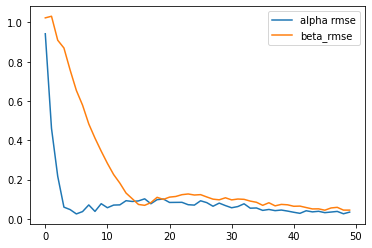

CPU times: user 34min 6s, sys: 5min 53s, total: 39min 59s
Wall time: 3min 3s


In [7]:
%%time

from core.torch_mxl import TorchMXL

# instantiate MXL model
mxl = TorchMXL(dcm_dataset, batch_size=num_resp, use_inference_net=False, use_cuda=True)

# run Bayesian inference (variational inference)
results = mxl.infer(num_epochs=5000, true_alpha=true_alpha, true_beta=true_beta)

The "results" dictionary containts a summary of the results of variational inference, including means of the posterior approximations for the different parameters in the model:

In [8]:
results

{'Estimation time': 180.31926941871643,
 'Est. alpha': array([-0.829606  ,  0.81315774,  1.2350409 ], dtype=float32),
 'Est. zeta': array([-0.80595   ,  0.8408898 ,  1.041418  , -0.84733564,  1.577763  ],
       dtype=float32),
 'Est. beta_n': array([[ 0.2527863 ,  1.2963054 ,  2.0226927 ,  0.0410569 ,  2.6035655 ],
        [-0.75236315,  1.3283943 ,  1.0242969 , -0.99383736,  1.757081  ],
        [ 0.20523058,  1.8672252 ,  2.3097181 ,  0.18797006,  1.9210131 ],
        ...,
        [-1.1407748 ,  0.84521985,  0.8143973 , -1.5126677 ,  1.1863397 ],
        [-0.8388351 ,  1.3187057 ,  1.8243117 ,  0.23306377,  1.9968318 ],
        [ 0.10205636,  1.1343317 ,  1.0688368 , -0.10653303,  1.0557183 ]],
       dtype=float32),
 'ELBO': 693668.0,
 'Loglikelihood': -640475.4375,
 'Accuracy': 0.4719580113887787}

This interface is currently being improved to include additional output information, but additional information can be obtained from the attributes of the "mxl" object for now. 